In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt

# GP exercise 1

Compute kernel 

In [12]:
def gaussian_kernel(X,Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)

In [13]:
gamma = 10 
S = np.linspace(0,1,100)

x = S[:, np.newaxis]
K_S = gaussian_kernel(x, x, gamma)


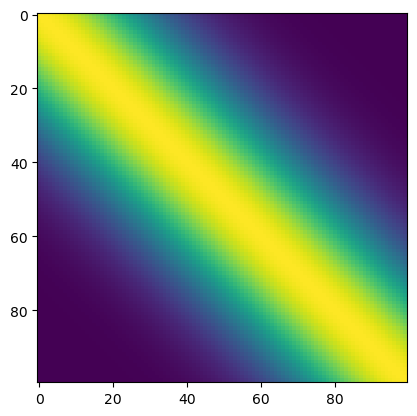

In [4]:
plt.imshow(K_S)
plt.show()

- Draw samples from Gaussian prior $p(f|S)$

In [31]:
n_samples = 10
samples = np.random.multivariate_normal(np.zeros(len(S)), K_S, n_samples)

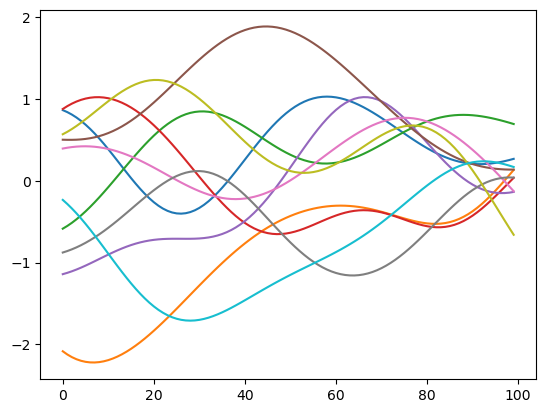

In [34]:
plt.plot(samples.T)
plt.show()

# GP exercise 2

Idea: 
- Pick a kernel - here the Gaussian kernel 
- Pick noise variance 
- Get data 
- Add noise variance 
- Condition on the noise measurements 

In [65]:
def gaussian_kernel(X,Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)

def conditional(X, y, X_predict, noise_var, eta, kernel):
    """ Condition on noise measurements """
    # See eq. 66 (75?) in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    
    # transform X 
    X = X[:, np.newaxis]
    X_predict = X_predict[:, np.newaxis]
    
    # calculate kernel matrices used in eq 75 
    K_S = kernel(X, X, eta) + noise_var * np.eye(len(X))  # K(S, S)
    K_star = kernel(X, X_predict, eta)  # K(S, X*)
    K_star_star = kernel(X_predict, X_predict, eta)  # K(X*, X*)
    
    # compute G 
    G = np.linalg.inv(noise_var**2 * np.eye(len(X)) + K_S) #(sigma_y^2*I + K(S))^-1
    
    # compute alpha = G*y
    alpha = G @ y
    
    # Use eq. 75 from lecture notes to calculate mu_star and sigma_star for new x
    mustar = K_star.T @ alpha # kernel(S, x∗)^T*alpha
    Sigmastar = K_star_star - K_star.T @ G @ K_star # kernel(x∗, x∗) − kernel(S, x∗)^T*G*kernel(S, x∗)
    
    return mustar, Sigmastar # return mean and covariance matrix

In [66]:
#load and normalize Mauna Loa data 
data = np.genfromtxt('/opt/streamline/jmj/Courses/PLM/co2_mm_mlo.csv', delimiter=',')
#10 years of data for learning
X = data[:120,2]-1958
y_raw = data[:120,3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw-y_mean)/y_std
#the next 5 years for prediction
X_predict = data[120:180,2]-1958
y_predict = data[120:180,3]

In [81]:
# use fixed parameters and gaussian kernel 
noise_var = 0.1
eta = 0.15
kernel = gaussian_kernel

# condition 
prediction_mean_gp, Sigma_gp = conditional(X, y, X_predict, noise_var, eta, kernel)

var_gp = np.diag(Sigma_gp) # We only need the diagonal term of the covariance matrix for the plots.

In [82]:
# Compute 95% confidence interval
lower = prediction_mean_gp - 1.96 * np.sqrt(var_gp)
upper = prediction_mean_gp + 1.96 * np.sqrt(var_gp)

# Postprocess mean for plotting
yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp * y_std**2
lower = yout_m - 1.96 * np.sqrt(yout_v)
upper = yout_m + 1.96 * np.sqrt(yout_v)

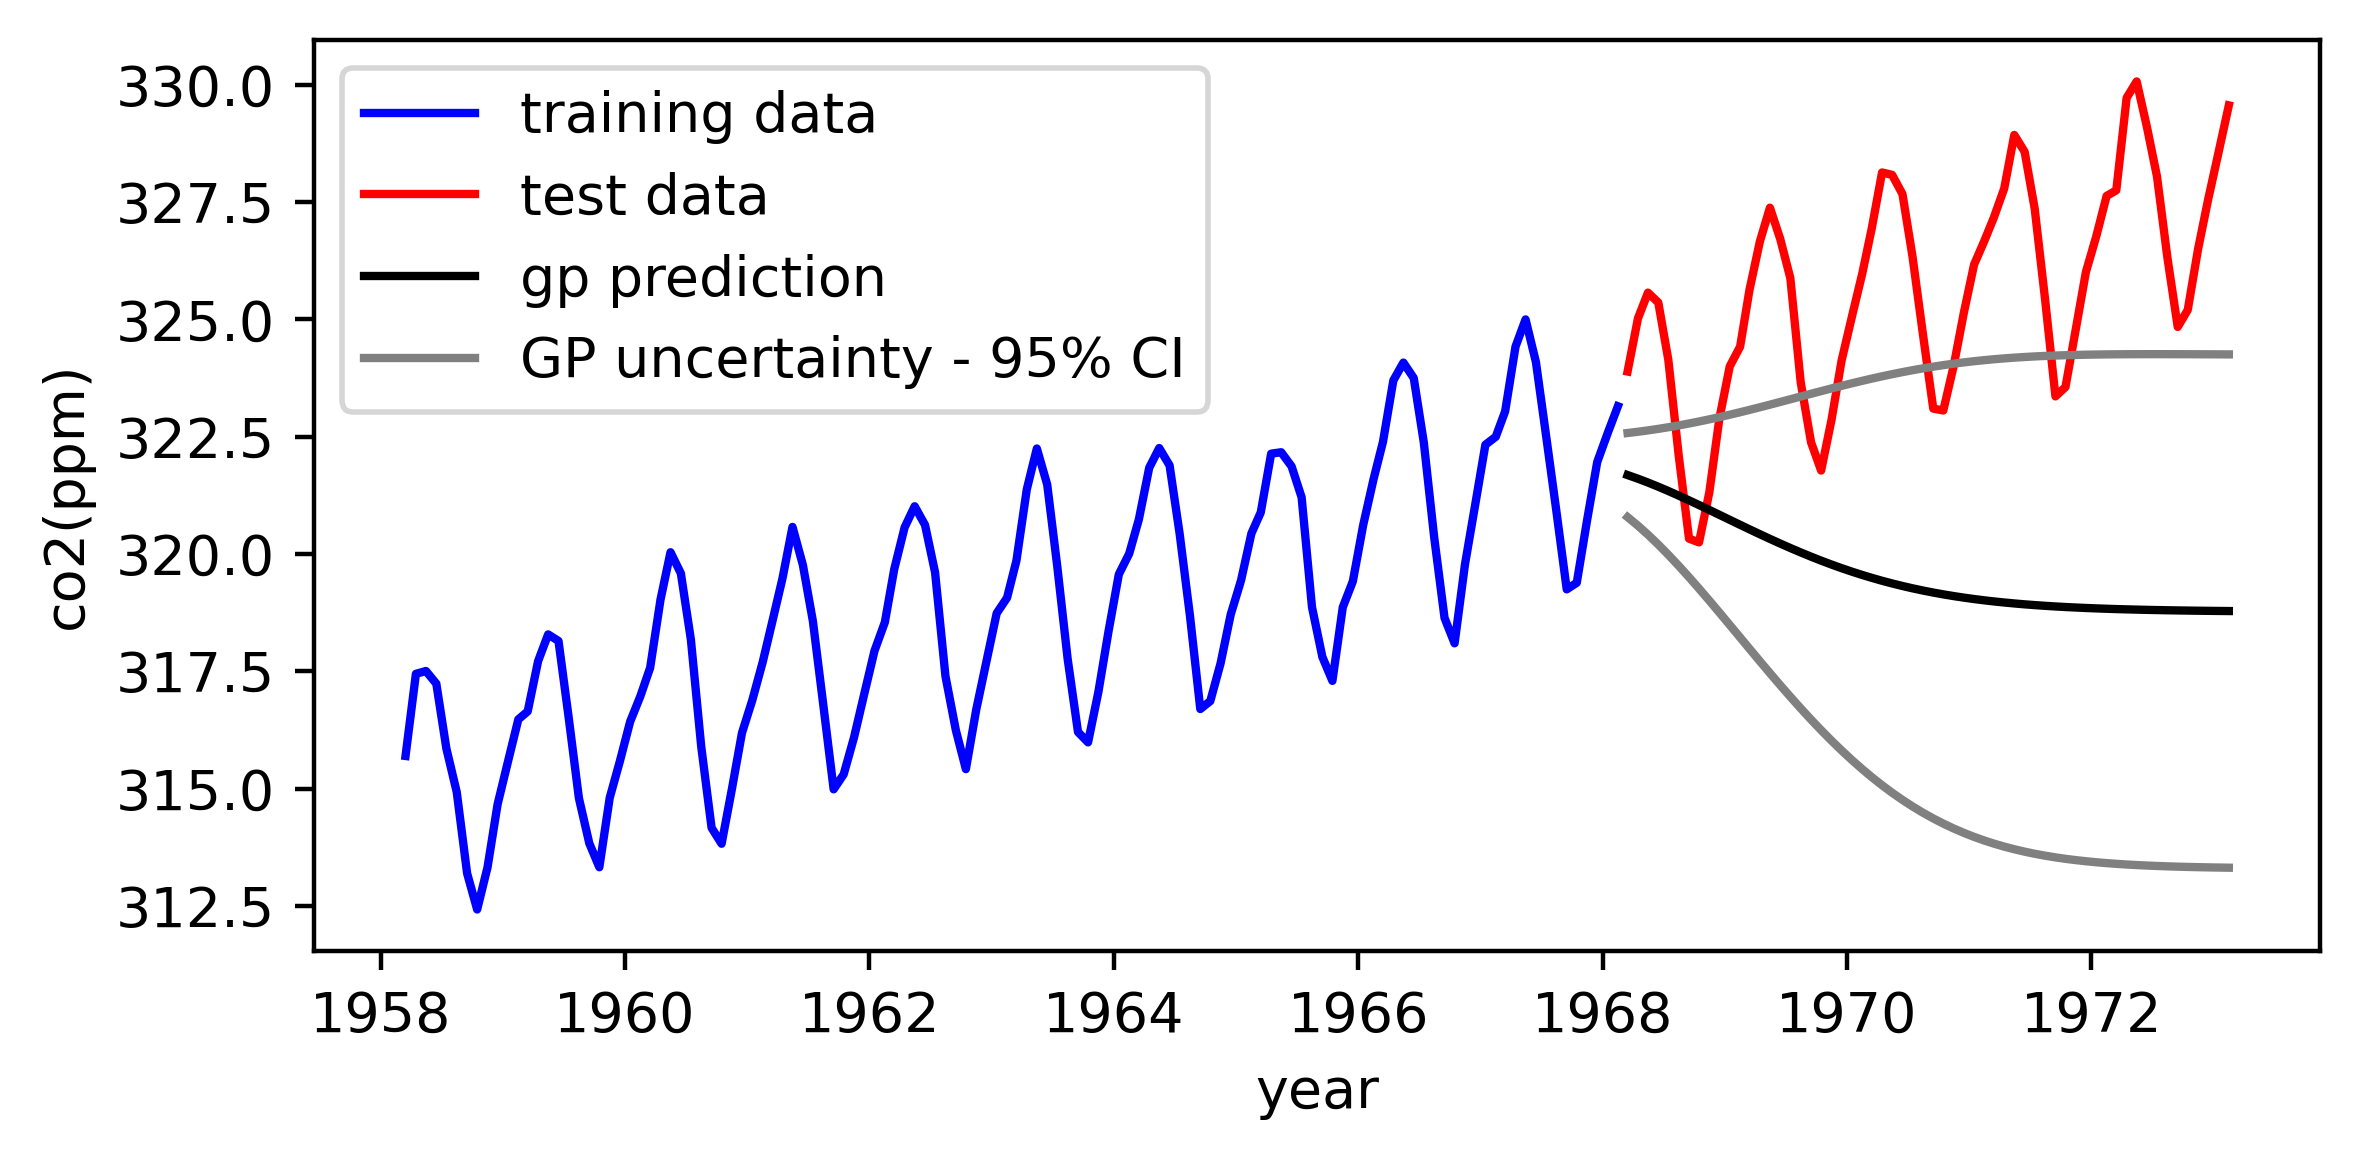

In [83]:
#plotting code for your convenience
plt.figure(dpi=400,figsize=(6,3))
plt.plot(X + 1958, y_raw, color='blue', label='training data')
plt.plot(X_predict + 1958, y_predict, color='red', label='test data')
# prediction
plt.plot(X_predict + 1958, yout_m, color='black', label='gp prediction')
plt.plot(X_predict + 1958, upper, color='grey', label='GP uncertainty - 95% CI')
plt.plot(X_predict + 1958, lower, color='grey')
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()
plt.show()